# Deep MIMO Detection

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Implementation and optimization of the deep MIMO detector *DetNet* introduced by [1]. This code implements *DetNet* closely to [1].

[1] N. Samuel, T. Diskin and A. Wiesel, "Deep MIMO detection," 2017 IEEE 18th International Workshop on Signal Processing Advances in Wireless Communications (SPAWC), Sapporo, 2017, pp. 1-5.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline 

W0718 11:29:03.070267 139734131406144 deprecation.py:323] From /home/simulation/MLenv/lib64/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


Our goal is to do a binary MIMO detection with a deep neural network as it is proposed in [1]. 
Given is a $K \times N$ MIMO channel. The channel matrix $\mathbf{H}$ is varying for each sample and is known to the detector. After applying AWGN, the detector receives the signal and detects the data bits.
The optimal **maximum likelihood detector** has a too high worst case computational complexity and is therefore impractical for many applications [1]. Existing suboptimal MIMO detectors are e.g. zero forcing, minimum mean squared error or the matched filter. The idea is, that a deep neural network gains better performance than the so far known suboptimal detectors without getting too computationally complex.

Lets first define our MIMO channel and generate data. 

In [2]:
# MIMO channel config
K = 30  # Tranmit antennas.
N = 60  # Receive antennas.
snr = 10.0  # SNR of channel in dB for the training.
snr_lin = 10.0 ** (snr/10.0)  # SNR of channel in lin.

# case VC: Varying channel (randomly generated channel matrix for each new sample).

# Function for training and test data generation according to the FC model of the paper.
def data_generation_VC(K, N, size, snr, snr_var):
    x = np.random.randint(2, size=(size, K))*2.0-1 # Random binary TX symbols.
    n = np.random.randn(size, N) # Random noise for each RX antenna.
    y = np.empty(shape=[size, N]) # RX dummy vector
    Hy = np.empty(shape=[size, K])
    HH = np.zeros([size, K, K])
    # Randomly vary the SNR
    current_snr = 10.0 ** (np.random.uniform(low=snr-snr_var,high=snr+snr_var, size=size)/10.0)
    for i in range(size):
        H = np.random.randn(N, K)*1.0/np.sqrt(N)  # Generate random and normalized channel.
        HH[i,:,:] = H.T.dot(H) # Calc (H^T H) as it is used as an input for the neural net.
        # Calc the output vector with additive noise which depends on the current SNR.
        y[i,:] = (H.dot(x[i,:])+n[i,:]*np.sqrt((HH[i,:,:]).trace()/K)/np.sqrt(current_snr[i]))
        Hy[i,:] = H.T.dot(y[i,:]) # Calc (H^T y) as it is used as an input for the neural net.
    return y, Hy, HH, current_snr, x


Configure and build the neural network.
Each layer has the 4 inputs $\mathbf{H}^{T}\mathbf{y}$, $\mathbf{H}^{T}\mathbf{H}$, $\mathbf{x}_k$ and $\mathbf{v}_k$. The index $k$ denotes the layer. The layers can also be interpreted as iterations of an optimization algorithm [1].

The nonlinear operation
$
\begin{align*}
&\quad \mathbf{z}_{k} = \rho\left(\text{W}_{1k}\begin{bmatrix}
\mathbf{H}^{T}\mathbf{y}\\
\hat{\mathbf{x}}_{k}\\
\mathbf{H}^{T}\mathbf{H}\hat{\mathbf{x}}_{k}\\
\mathbf{v}_{k}
\end{bmatrix}+\mathbf{b}_{1k}\right)\\
&\hat{\mathbf{x}}_{k+1} = \psi_{t_{k}}(\mathbf{W}_{2k}\mathbf{z}_{k}+\mathbf{b}_{2k})\\
&\hat{\mathbf{v}}_{k+1} = \mathbf{W}_{3k}\mathbf{z}_{k}+\mathbf{b}_{3k}\\
&\qquad\hat{\mathbf{x}}_{1} = \mathbf{0}\tag{10}
\end{align*}
$
is applied to the input. $\mathbf{x}_0$ is the received data vector.

Summarized, each layer does roughly the following steps:
* Concatenate the inputs.
* Linear transformation.
* Apply ReLU function.
* Calculate $\mathbf{v}_{k+1}$ as a linear trafo of the ReLU output.
* Calculate $\mathbf{x}_{k+1}$ as a linear trafo of the ReLU output which is then fed to the linear soft sign function.


In [3]:
tf.reset_default_graph() # Reset tf graph.

# DetNet config
layers = 3*K
v_len = 2*K
z_len = 8*K

# Training params
training_steps = 10000
batch_size_train = 5000
snr_var_train = 3.0 # Maximum absolute deviation of the SNR from its mean in logarithmic scale.

# Test params
test_steps= 1000
batch_size_test = 5000
snr_range = np.arange(8, 14, 1)

# Definition of the piecewise linear soft sign operator.
def linear_soft_sign(x):
    # Comment_LS: Würde es einen Vorteil bringen, hier mit einem Zufallswert (e.g., zw. 0-1) zu initialisieren anstelle mit 0.3? War die 0.3 nur eine Annahme oder woher kommt die?
    t = tf.Variable(np.random.uniform())
    y = -1+tf.nn.relu(x+t)/(tf.abs(t))-tf.nn.relu(x-t)/(tf.abs(t))
    return y

# Definition of a basic linear transformation layer.
def linear_trafo(x, input_size, output_size):
    W = tf.Variable(tf.random_normal([input_size, output_size], stddev=0.01))
    w = tf.Variable(tf.random_normal([1, output_size], stddev=0.01))
    y = tf.matmul(x, W) + w
    return y

# Start tensorflow session.
sess = tf.InteractiveSession()
# Inputs of the DetNet.
x_input = tf.placeholder(tf.float32,shape=[None,K])
Hy_input = tf.placeholder(tf.float32,shape=[None,K])
HH_input = tf.placeholder(tf.float32,shape=[None, K , K])

# Calculate optimal decorrelation decoder to normalize the loss function later on.
x_opt = tf.squeeze(tf.matmul(tf.expand_dims(Hy_input,1),tf.matrix_inverse(HH_input)), 1)

# Define initial iteration variables.
x = []
x.append(tf.zeros([tf.shape(x_input)[0], K]))
v = []
v.append(tf.zeros([tf.shape(x_input)[0], v_len]))
l = []
l.append(tf.zeros([]))
ber = []
ber.append(tf.zeros([]))
ber_zf = []
ber_zf.append(tf.zeros([]))

# Build DetNet layers.
for i in range(1,layers+1):
    # Concatenate the 4 inputs Hy, v, x and HH.
    concat = tf.concat([Hy_input, v[-1], x[-1], tf.squeeze(tf.matmul(tf.expand_dims(x[-1], 1), HH_input), 1)],1)
    
    # Apply linear transformation and rectified linear unit (ReLU).
    z = tf.nn.relu(linear_trafo(concat, 3*K + v_len, z_len))
    
    # Generate new x iterate with a final linear trafo.
    x.append(linear_soft_sign(linear_trafo(z, z_len, K)))
    
    # Generate new v iterate with a final linear trafo.
    v.append(linear_trafo(z , z_len , v_len))
    
    # Calculate loss after each DetNet layer. This loss is normalized to the error of the optimal decorrelator decoder.
    l.append(np.log(i)*tf.reduce_mean(tf.reduce_mean(tf.square(x_input - x[-1]),1)/tf.reduce_mean(tf.square(x_input - x_opt),1)))
    
    # Calc bit error rate (ber).
    ber.append(tf.reduce_mean(tf.cast(tf.not_equal(x_input, tf.sign(x[-1])), tf.float32)))
    
    # Calc bit error rate (ber_zf) of zero forcing equalizer as a reference.
    ber_zf.append(tf.reduce_mean(tf.cast(tf.not_equal(x_input, tf.sign(x_opt)), tf.float32)))


Training of the network.
The loss function takes into account the output of all the layers $\mathcal{L}$ and is normalized to the loss of a zero forcing equalizer $\Vert \mathbf{x}-\tilde{\mathbf{x}}\Vert^{2}$. The loss function is defined as:
\begin{align*}
&L(\mathbf{x};\hat{\mathbf{x}}_{\theta}(\mathbf{H}, \mathbf{y}))=\sum_{k=1}^{\mathcal{L}}\log(k)\frac{\Vert \mathbf{x}-\hat{\mathbf{x}}_{k}\Vert ^{2}}{\Vert \mathbf{x}-\tilde{\mathbf{x}}\Vert^{2}},\tag{13}\\
\text{where}:\\
&\qquad\qquad \tilde{\mathbf{x}}=(\mathbf{H}^{T}\mathbf{H})^{-1}\mathbf{H}^{T}\mathbf{y}.
\tag{14}
\end{align*}

In [4]:
# Global loss function takes into account the loss of all the DetNet layers.
loss = tf.add_n(l)
# Use stochastic gradient descent methode Adam to train the network.
train_step = tf.train.AdamOptimizer().minimize(loss)

# Run Tensorflow session.
sess.run(tf.initialize_all_variables())

# Training.
tmp_result = []
ber_samples = np.zeros((np.floor_divide(training_steps,100), len(snr_range), test_steps))

for i in range(training_steps):
    # Generate a batch of training data.
    y_train, Hy_train, HH_train, snr_train, x_train = data_generation_VC(K, N, batch_size_train, snr, snr_var_train)
    # Feed the training data to network.
    train_step.run(feed_dict={Hy_input: Hy_train, HH_input: HH_train, x_input: x_train})
    if i%500 == 0:
        tmp_result.append(sess.run([l, ber], {Hy_input: Hy_train, HH_input: HH_train, x_input: x_train}))
        print('Train step ', i, ', current loss: ', tmp_result[-1][0][-1], ', current ber: ', tmp_result[-1][1][-1])
                

W0718 11:29:22.367292 139734131406144 deprecation.py:323] From /home/simulation/MLenv/lib64/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py:197: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Train step  0 , current loss:  26.19094 , current ber:  0.41979334
Train step  500 , current loss:  0.2584979 , current ber:  0.0053333333
Train step  1000 , current loss:  0.26254472 , current ber:  0.0052133333
Train step  1500 , current loss:  0.28338882 , current ber:  0.0058333334
Train step  2000 , current loss:  0.25567567 , current ber:  0.0053533334
Train step  2500 , current loss:  0.2785363 , current ber:  0.00532
Train step  3000 , current loss:  0.26956657 , current ber:  0.00524
Train step  3500 , current loss:  0.2662639 , current ber:  0.0053666667
Train step  4000 , current loss:  0.29843265 , current ber:  0.0059066666
Train step  4500 , current loss:  0.28502527 , current ber:  0.005693333
Train step  5000 , current loss:  0.28368083 , current ber:  0.0057733334
Train step  5500 , current loss:  0.28042355 , current ber:  0.00536
Train step  6000 , current loss:  0.26724112 , current ber:  0.005386667
Train step  6500 , current loss:  0.2752312 , current ber:  0.0054

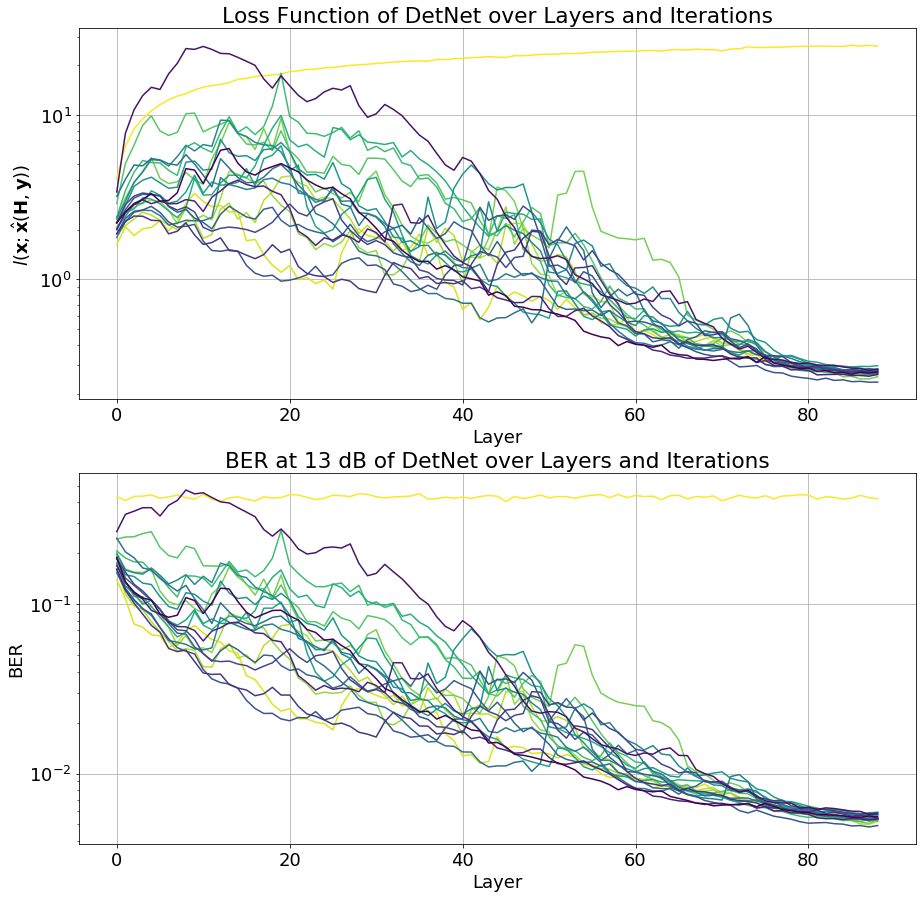

In [5]:
# Visualize Training.

fig = plt.figure(1,figsize=(15,15))
plt.rcParams.update({'font.size': 18})
color=iter(cm.viridis_r(np.linspace(0,1,np.size(tmp_result, 0))))
# Plot loss.
plt.subplot(211)
for i in range(0, np.size(tmp_result, 0)):
    c=next(color)
    plt.semilogy(range(0, np.size(tmp_result, 2)-2), tmp_result[i][0][2:], color=c)
plt.grid(True)
plt.title("Loss Function of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel(r"$l(\mathbf{x};\hat{\mathbf{x}}(\mathbf{H}, \mathbf{y}))$")
# Plot BER.
plt.subplot(212)
color=iter(cm.viridis_r(np.linspace(0,1,np.size(tmp_result, 0))))
for i in range(0, np.size(tmp_result, 0)):
    c=next(color)
    plt.semilogy(range(0, np.size(tmp_result, 2)-2), tmp_result[i][1][2:], color=c)
plt.grid(True)
plt.title("Average BER over SNR range of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_layers.pdf", format='pdf')

Test the network with different SNR scenarios.

In [7]:
ber_test = np.zeros((len(snr_range), test_steps))
ber_zf_test = np.zeros((len(snr_range), test_steps))
for c, tmp_snr in enumerate(snr_range):
    for i in range(test_steps):
        y_test, Hy_test, HH_test, snr_test, x_test= data_generation_VC(K, N, batch_size_test, tmp_snr, 0.0)
        bers = np.array(sess.run([ber[layers-1], ber_zf[layers-1]], {Hy_input: Hy_test, HH_input: HH_test, x_input: x_test}))
        ber_test[c][i] =  bers[0]
        ber_zf_test[c][i] = bers[1]
    print('SNR ', tmp_snr, 'BER = ', np.mean(ber_test[c]), ' ZF = ', np.mean(ber_zf_test[c]))

SNR  8 BER =  0.013163773318752646  ZF =  0.040277606703341004
SNR  9 BER =  0.005920913329813629  ZF =  0.025636400001123546
SNR  10 BER =  0.0023422399983974176  ZF =  0.014992906658910215
SNR  11 BER =  0.0008066866673761979  ZF =  0.007913193333894014
SNR  12 BER =  0.00024130000098375603  ZF =  0.0037267399947158992
SNR  13 BER =  6.576666677938192e-05  ZF =  0.0015177800019737333


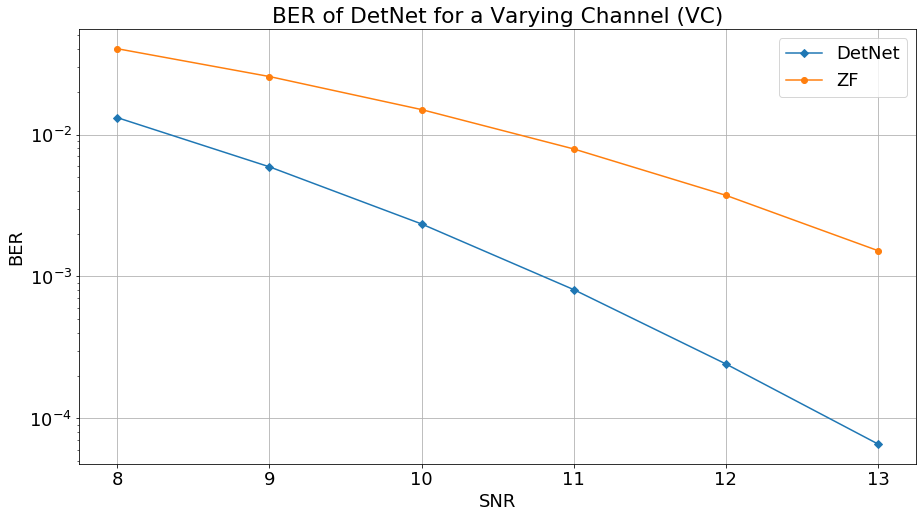

In [8]:
# Plot BER curve.
fig = plt.figure(1,figsize=(15,8))
ber_res = np.mean(ber_test, axis=1)
ber_zf_res = np.mean(ber_zf_test, axis=1)
plt.figure(1,figsize=(15,8))
plt.rcParams.update({'font.size': 18})
plt.semilogy(snr_range, ber_res, marker='D')
plt.semilogy(snr_range, ber_zf_res, marker='o')
plt.legend(['DetNet', 'ZF'])
plt.grid(True)
plt.title("BER of DetNet for a Varying Channel (VC)")
plt.xlabel("SNR")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_BER.pdf", format='pdf')